# Stock Prediction using CNN

**Prerequisite**
```!pip install pandas_datareader --user```

In [1]:
import sys
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like

from pandas_datareader import data as pdr
from tqdm import tqdm,trange

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
stock_list = ['KBANK','SCB','BBL','KTB','AOT','BEAUTY']

In [3]:
stock_data = []
stock_name = []
for quote in tqdm(stock_list):
    try:
        stock_data.append(pdr.get_data_yahoo('{}.BK'.format(quote), start='2010-01-01', end='2018-11-30'))
        stock_name.append(quote)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

Using TensorFlow backend.


In [0]:
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = Y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test
  
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [14]:
stock_data[0].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,85.50,84.00,85.25,84.50,2410100.0,66.080788
2010-01-05,85.25,84.25,85.00,84.50,4058600.0,66.080788
2010-01-06,86.00,84.75,85.00,85.75,9900800.0,67.058311
2010-01-07,87.75,86.25,86.50,86.75,13073500.0,67.840332
2010-01-08,88.25,86.75,87.50,88.00,10187600.0,68.817856


In [18]:
data_original = stock_data[0]

openp = data_original['Open'].tolist()
highp = data_original['High'].tolist()
lowp = data_original['Low'].tolist()
closep = data_original['Adj Close'].tolist()
volumep = data_original['Volume'].tolist()

# data_chng = data_original.ix[:, 'Adj Close'].pct_change().dropna().tolist()

WINDOW = 10
EMB_SIZE = 5
STEP = 1
FORECAST = 1

X, Y = [], []
for i in range(0, len(data_original), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        o = (np.array(o) - np.mean(o)) / np.std(o)
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)

#         x_i = closep[i:i+WINDOW]
        y_i = closep[i+WINDOW+FORECAST]  

#         next_close = y_i

#         if last_close < next_close:
#             y_i = [1, 0]
#         else:
#             y_i = [0, 1] 

        x_i = np.column_stack((o, h, l, c, v))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))


model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=16,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(nb_filter=8,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())


model.add(Dense(1))
# model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
# checkpointer = ModelCheckpoint(filepath="lolkek.hdf5", verbose=1, save_best_only=True)


model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

model.fit(X_train,Y_train,epochs=150,verbose=1)
pred = model.predict(np.array(X_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(10, 5), filters=16, kernel_size=4, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=8, kernel_size=4, padding="same")`


Epoch 1/150
1951/1951 [==============================] - 8s 4ms/step - loss: 21947.9936 - mse: 21947.9961
Epoch 2/150
1951/1951 [==============================] - 0s 234us/step - loss: 20562.9851 - mse: 20562.9844
Epoch 3/150
1951/1951 [==============================] - 0s 225us/step - loss: 18443.4881 - mse: 18443.4863
Epoch 4/150
1951/1951 [==============================] - 0s 221us/step - loss: 15579.4836 - mse: 15579.4834
Epoch 5/150
1951/1951 [==============================] - 0s 222us/step - loss: 12230.5648 - mse: 12230.5625
Epoch 6/150
1951/1951 [==============================] - 0s 225us/step - loss: 8864.8787 - mse: 8864.8799
Epoch 7/150
1951/1951 [==============================] - 0s 234us/step - loss: 6011.3457 - mse: 6011.3442
Epoch 8/150
1951/1951 [==============================] - 0s 227us/step - loss: 3878.2543 - mse: 3878.2542
Epoch 9/150
1951/1951 [==============================] - 0s 222us/step - loss: 2582.8424 - mse: 2582.8423
Epoch 10/150
1951/1951 [==============

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

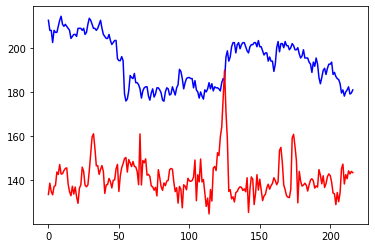

In [20]:
plt.plot(Y_test,'b')
plt.plot(pred,'r')

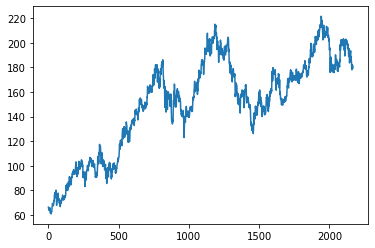

In [21]:
plt.plot(Y)